In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model,to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [2]:
data_dir = Path("lemon_dataset/")
images = []
labels = []

label_name = {'empty_background': 0, 'bad_quality': 1, 'good_quality': 2}
for x in os.walk(data_dir):
    if x[0] == 'lemon_dataset':
        continue
    label = x[0].split('\\')[1]
    for file in os.listdir(x[0]):
        imagePath = f"{x[0]}\\{file}"
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (227,227))
        if image.shape[2] == 1:
            img = np.dstack([image,image,image])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255
        
        images.append(image)
        labels.append(label_name[label])
print("Data has been processed")

Data has been processed


In [3]:
#Creation of Alexnet Architecture
model = keras.models.Sequential()
num_output = 3
model.add(Conv2D(filters = 96, input_shape = (227, 227, 3), 
            kernel_size = (11, 11), strides = (4, 4), 
            padding = 'valid'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size =(2,2), strides = (2,2), padding='valid'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size = (11, 11), 
            strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), 
            padding = 'valid'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 384, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))

model.add(Activation('relu'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 384, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))

model.add(Activation('relu'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), 
            padding = 'valid'))

model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(4096, input_shape = (224*224*3, )))
model.add(Activation('relu'))

model.add(Dropout(0.4))

model.add(BatchNormalization())

model.add(Dense(4096))
model.add(Activation('relu'))


model.add(Dropout(0.4))

model.add(BatchNormalization())
  

model.add(Dense(num_output))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [4]:
#Running of model with k-fold = 5
total_history = []
n_folds = 5
for x in range(n_folds):
    (x_train, x_test, y_train, y_test) = train_test_split(images, labels, test_size = 0.3)
    y_train = to_categorical(y_train, num_classes = 3)
    y_test = to_categorical(y_test, num_classes = 3)
    x_train = np.asarray(x_train)
    x_test = np.asarray(x_test)
    print(f"Current Fold is {x+1}")
    total_history.append(model.fit(x=x_train,y= y_train, 
                            epochs = 10, 
                            batch_size=128, validation_data= (x_test,y_test)))

Current Fold is 1
Epoch 1/10
14/14 [==============================] - 26s 2s/step - loss: 1.5208 - accuracy: 0.7620 - val_loss: 180.4288 - val_accuracy: 0.4493
Epoch 2/10
14/14 [==============================] - 25s 2s/step - loss: 0.3174 - accuracy: 0.8830 - val_loss: 104.5080 - val_accuracy: 0.4506
Epoch 3/10
14/14 [==============================] - 26s 2s/step - loss: 0.2127 - accuracy: 0.9073 - val_loss: 57.4977 - val_accuracy: 0.4532
Epoch 4/10
14/14 [==============================] - 25s 2s/step - loss: 0.1553 - accuracy: 0.9429 - val_loss: 31.6338 - val_accuracy: 0.4638
Epoch 5/10
14/14 [==============================] - 25s 2s/step - loss: 0.1307 - accuracy: 0.9446 - val_loss: 7.3029 - val_accuracy: 0.6324
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 0.1320 - accuracy: 0.9469 - val_loss: 2.3532 - val_accuracy: 0.6970
Epoch 7/10
14/14 [==============================] - 25s 2s/step - loss: 0.1302 - accuracy: 0.9457 - val_loss: 0.6711 - val_accuracy: 0.7

24/24 [==============================] - 2s 94ms/step
                  precision    recall  f1-score   support

empty_background       1.00      1.00      1.00       131
     bad_quality       0.99      0.98      0.98       257
    good_quality       0.98      0.99      0.99       371

        accuracy                           0.99       759
       macro avg       0.99      0.99      0.99       759
    weighted avg       0.99      0.99      0.99       759



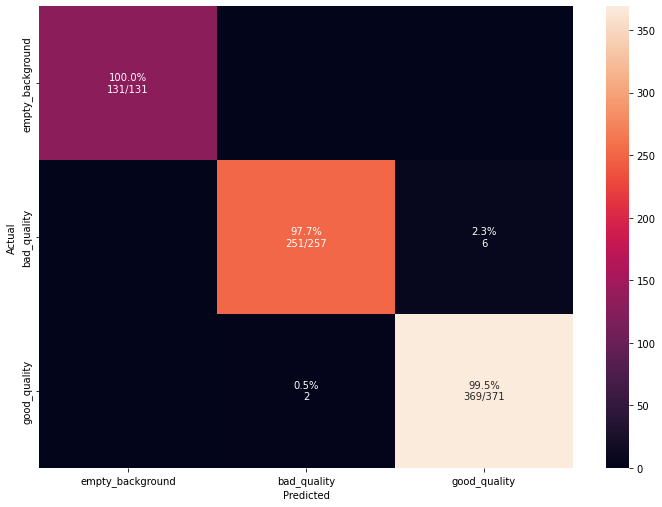

In [23]:
#Creation of confusion
matrix_index = ['empty_background', 'bad_quality', 'good_quality']

preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
plt.tight_layout()
sn.heatmap(df_cm, annot=annot, fmt='')
fig.savefig("Confusion_Matrix_Heatmap.jpg", dpi=300)